# Mini-2 

**Name:** *Ashutosh Kumar*  
**Course:** EECS 590 Reinforcement Learning  
**Mini 2_Solution**

## Preliminary

Augment your abstract classes you worked on in Mini Project 1 in the following way:
1. Create a class for Markov Decision Processes (MDPs) that takes advantage of how you defined
Markov Reward Processes.

2. For each problem, formulate the situation as an MDP. Clearly define:

- the initial measure, μ; that is, the starting positions of your agent.
- The policy π : S × ΣA → [0, 1]. Or equivalently, the action dynamics π(a | s)
- The kernel κ: S ×A×ΣS → [0, 1]. Or equivalently, the transition dynamics P(s′ | s, a)).
- The reward kernel R: S × B(R) → [0, 1]. Or equivalently, The reward function R(s) =
E(Rt+1 | St = s).1
- γ, returns, values and q−values.
- Policy iteration and value iteration.

In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
rng = np.random.default_rng(0)

## Finite Markov Process and Markov Reward Process

These are the same core class abstractions I used in Mini-1, with small renaming tweaks. They represent:
- A **finite Markov process** $(S, P)$ with a sparse transition matrix.
- A **finite Markov reward process** $(S, P, R, \gamma)$ and Bellman-based solvers.

In [2]:
from dataclasses import dataclass # Keeps the class definition short and readable
from typing import Dict, Tuple, List, Any, Optional #type hints. They are not required for Python to run but help our editor/IDE (VS Code, PyCharm) catch bugs,
@dataclass #I am using this decorator instead of __init__ as with this python autogenerate many constructor
class FiniteMarkovProcess:
    #This class represents a finite Markov process with state set S and transition matrix P.
    """ Finite Markov Process (S,P). """
    states: List[Any] # I am not pinning down the exact state type.
    P: sp.csr_matrix # this is transition matrix P, CSR format only stores non-zeros → big memory savings.
    def n_states(self) -> int:
        return len(self.states)

    def validate_row_stochastic(self,tol:float =1e-9) -> None:
        row_sums = np.asarray(self.P.sum(axis=1)).ravel() # summing along column to get one sum per row
        nonzero_rows = row_sums > tol #ignoring empty rows
        max_err = np.max(np.abs(row_sums[nonzero_rows] - 1.0)) if np.any(nonzero_rows) else 0.0 #compute maximum error
        if max_err > 1e-6:
            raise ValueError(f"Transition matrix rows not stochastic enough. max_err={max_err}") #checking if error is too big

    def next_state_distribution(self, s_idx:int) -> Dict[int, float]:
        row = self.P.getrow(s_idx) #to return the sparse row object
        return {int(c): float(p) for c, p in zip(row.indices, row.data)} #row.indices --> build a dir to give me columns where we have non-zero values and row.data --> gives me the values
          
# Mathematically, above code is implementing the object: (S,P): a finite Markov process 
#===================================================================================================================================================
@dataclass
class FiniteMRP(FiniteMarkovProcess): #inherits from class FiniteMarkovProcess so already has states, P and other methods like n_states() etc.
    """Finite Markov Reward Process (S, P, R, gamma)."""
    R: np.ndarray #adding reward vector 
    gamma: float  #discount factor we will use between 0 to 1

    def validate(self) -> None: # adding for sanity check only and to ensure accuracy for MRP is defined correct
        if not(0.0 <= self.gamma <=1.0):
            raise ValueError("gamma must be in [0,1].") # if we accidently use value for gamma outside 0 and 1 it will raise error
        if self.R.shape != (self.n_states(),):
            raise ValueError("R must have shape (n_states,)).") # this is to ensure the shape of states n and Rewards R are same
        self.validate_row_stochastic()     #inherited method from previous class that checks P
    def bellman_equation(self, V:np.ndarray) -> np.ndarray:
        return self.R +self.gamma * (self.P @ V) #core bellman equation code for V = R + gamma PV

    def value_iteration(self, tol: float = 1e-10, max_iter: int = 50_000, V0: Optional[np.ndarray] = None): #implementing valu iteration for MRPs
        n= self.n_states()
        V = np.zeros(n) if V0 is None else V0.copy() #starting V with 0 or provided values if any
        deltas = []  #to store how much V changes from one iteration to next 
        snapshots = [] # just to store copies of V, I am planning to use this for animation of plot
        for _ in range(max_iter): #main loop
            snapshots.append(V.copy())
            V_new = self.bellman_equation(V) #apply bellman
            delta = np.max(np.abs(V_new - V)) #maximum absolute chnage calculation
            deltas.append(delta)
            V = V_new  #update the current value funct
            if delta < tol :  # to stop once we think we are close enough to true solution
                snapshots.append(V.copy())
                break
        return V, np.array(deltas), snapshots
        
    def solve_linear_system(self):
        n = self.n_states()
        A = sp.eye(n, format = 'csr') -self.gamma * self.P #using sp.eye from scipy lib to create n x n identity matrix in sparse form
        try:
            V = spla.spsolve(A, self.R)
            return np.asarray(V), {"method" : "spsolve", "converged": True}
        except Exception:
            V, exit_code = spla.gmres(A, self.R, atol = 0, tol = 1e-10, restart=200, maxiter = 10_000)
            return np.asarray(V), {"method" : "gmres", "converged": exit_code == 0, "exit_code": exit_code}  #gmres is used on class slide too
 #referance: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.html  
 # https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.gmres.html   

In [3]:
@dataclass
class FiniteMDP: #Defining a new class here to represent Finite Markov Decision process
    """Finite MDP with tabular dynamics.  """
    states: List[Any]      #list of state labels.
    actions: List[Any]     #list of actions 
    P_a: Dict[Any, sp.csr_matrix]  #dict mapping action -> sparse (n x n) transition matrix
    R_s: np.ndarray        # reward vector of length n
    gamma: float           #discount factor

    def n_states(self) -> int:
        return len(self.states) #Count how many states we have

    def validate(self) -> None:  # this function is to validate and check the MDP data and raise error if anything is wrong
        n = self.n_states() # get how many states
        if self.R_s.shape != (n,):  #check for reward vector is an array for length n
            raise ValueError("R_s must have shape (n_states,).")
        if not (0.0 <= self.gamma <= 1.0):  
            raise ValueError("gamma must be in [0,1].") #check gamma is between [0,1] and error if it's not
        for a, P in self.P_a.items(): #using for loop on action and transition matrix P
            if P.shape != (n, n):    #check for P is of size n*n
                raise ValueError(f"P_a[{a!r}] has wrong shape: {P.shape}.")
            row_sums = np.asarray(P.sum(axis=1)).ravel() #sum each row across column 
            nonzero_rows = row_sums > 1e-9  #check in case there are no all 0 or weired values by mistake
            max_err = np.max(np.abs(row_sums[nonzero_rows] - 1.0)) if np.any(nonzero_rows) else 0.0 # for all non zero rows computing row sum and validate
            if max_err > 1e-6: # if largest absolute difference is >1e-6 we raise error ensure rows are stochastic
                raise ValueError(f"Transition rows for action {a!r} are not stochastic enough.")

    def induced_mrp(self, pi: Dict[int, Dict[Any, float]]) -> FiniteMRP:
        """Build the induced MRP from a (possibly stochastic) policy.

        pi[s][a] = probability of taking action a in state index s.

        (This is where I am connecting the MDP with MRP to take advantage of the defined markow reward process later.
        that's why I am calling this induced MRP where MDP meets policy pi)
        """
        n = self.n_states()
        rows: List[int] = []
        cols: List[int] = []
        data: List[float] = []
        for s in range(n):
            action_dist = pi[s] #for each states s getting action destribution
            for a, prob in action_dist.items():
                if prob == 0.0:
                    continue #skip the iteration if prob == 0 and move to next iteration
                Pa = self.P_a[a].getrow(s)
                for c, p in zip(Pa.indices, Pa.data): #taking pa.indices where row is non-zero and Pa.data for corresponding  probability
                    rows.append(s)
                    cols.append(int(c))
                    data.append(float(prob * p))
        P_pi = sp.csr_matrix((data, (rows, cols)), shape=(n, n)) #builds CSR matrix from P pi
        return FiniteMRP(states=self.states, P=P_pi, R=self.R_s, gamma=self.gamma) #create finite MRP using states, transition matrix, reward and gamma

    def greedy_policy_from_V(self, V: np.ndarray) -> Dict[int, Dict[Any, float]]:
        """Return a deterministic greedy policy given a value function V.

        pi[s] is a dict with a single action having probability 1.
        """
        n = self.n_states()
        pi: Dict[int, Dict[Any, float]] = {} #empty dict to fill with policies of each states
        for s in range(n):
            best_a = None  # best action found so far (not yet)
            best_q = -np.inf #infinity for any real q-value
            for a in self.actions:
                Pa = self.P_a[a].getrow(s) #Row s of the transition matrix for action a 
                q_sa = self.R_s[s] + self.gamma * float(Pa.dot(V)) #dot product of row s of P_a with V
                if q_sa > best_q:
                    best_q = q_sa # If this action produces a higher q-value than what we had before, update
                    best_a = a
            pi[s] = {best_a: 1.0} # For this state s, we set pi s to be a dict with only the best action and probability 1
        return pi     #Return the full greedy policy

    def policy_iteration(self, tol: float = 1e-10, max_eval_iter: int = 50_000,
                         max_pi_iter: int = 100):
        """Classical policy iteration: alternate evaluation and improvement.
        --> tol: tolerance for policy evaluation (value iteration).
        --> max_eval_iter: max number of value-iteration steps when evaluating a policy.
        --> max_pi_iter: max number of policy improvement iterations.
        """
        n = self.n_states()
        # Start with an arbitrary deterministic policy (e.g., always first action)
        pi: Dict[int, Dict[Any, float]] = {s: {self.actions[0]: 1.0} for s in range(n)} #initializing pi, choosing first action  with probability 1
        V = np.zeros(n) #starting with zero value for all states
        for _ in range(max_pi_iter):
            mrp = self.induced_mrp(pi) #For the current policy pi, build the induced FiniteMRP.
            V, deltas, _ = mrp.value_iteration(tol=tol, max_iter=max_eval_iter, V0=V) #using value iteration mething to approximate V
            new_pi = self.greedy_policy_from_V(V)  #policy improvement
            if all(pi[s] == new_pi[s] for s in range(n)):
                break  # If the policy doesn’t change after improvement (for all states), we’ve converged to an optimal policy.
            pi = new_pi #Otherwise, update pi and keep iterating.
        return pi, V  #Return the final policy and its value function.

    def value_iteration_control(self, tol: float = 1e-10, max_iter: int = 50_000,
                                V0: Optional[np.ndarray] = None):
        """Value iteration for optimal control. This is value iteration using the control Bellman optimality equation.

        Returns (V_star, pi_star, deltas).
        """
        n = self.n_states()
        V = np.zeros(n) if V0 is None else V0.copy()
        deltas: List[float] = []  # This is value iteration using the control Bellman optimality equation
        for _ in range(max_iter):
            V_new = np.empty_like(V)
            for s in range(n):
                q_vals = []
                for a in self.actions:
                    Pa = self.P_a[a].getrow(s)
                    q_sa = self.R_s[s] + self.gamma * float(Pa.dot(V))
                    q_vals.append(q_sa)
                V_new[s] = max(q_vals)
            delta = float(np.max(np.abs(V_new - V))) # maximum absolute change across all states.
            deltas.append(delta)
            V = V_new
            if delta < tol:
                break
        pi_star = self.greedy_policy_from_V(V) # Get the greedy policy from the final V, call it pi_star
        return V, pi_star, np.array(deltas)

In [4]:
def plot_grid(values_2d: np.ndarray, title: str = "", show_numbers: bool = False):
    grid = values_2d.copy().astype(float)
    grid[np.isneginf(grid)] = np.nan
    plt.figure(figsize=(6, 4))
    im = plt.imshow(grid, origin="lower")
    plt.title(title)
    plt.xticks(range(grid.shape[1]))
    plt.yticks(range(grid.shape[0]))
    plt.colorbar(im)
    if show_numbers:
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                if np.isfinite(values_2d[i, j]):
                    plt.text(j, i, f"{values_2d[i,j]:.1f}", ha="center", va="center", fontsize=7)
    plt.tight_layout()
    plt.show()

def values_to_grid(mask: np.ndarray, state_to_idx: Dict[Tuple[int, int], int], V: np.ndarray):
    out = np.full(mask.shape, np.nan, dtype=float)
    for (i, j), idx in state_to_idx.items():
        out[i, j] = V[idx]
    return out

# Problem 1 – Navigating a Windy Chasm

A drone must navigate through a windy chasm from a start position to a goal position. The
environment is a 20 × 7 grid where the drone starts at position (0, 3) and must reach the exit of
the chasm defined by (19, n) for any of the 7 possible choices for n.
## Environment Dynamics
The drone has three actions available: forward (increase i by 1), left (decrease j by 1), and right
(increase j by 1). However, wind currents create stochastic transitions:
- When the drone is at position (i, j) and takes an action, it first moves deterministically according
to that action.
- After the action, wind effects apply based on the distance from the center line (j = 3):
    - If the drone ends at (i, 3): with probability p, the wind pushes it to either (i, 4) or (i, 2)
    (50/50); otherwise, with probability (1 − p)p2, it pushes to (i, 5) or (i, 1); otherwise, with
    probability (1 − p)(1 − p2), it stays at (i, 3).
    - If the drone ends at (i, j) where j ̸= 3  : the wind probabilities scale with distance from
    center. Specifically, p is a function of j by the formula

$$p(j) = B^{E(j)},  where   \quad E(j) = \frac{1}{1 + (j-3)^2}$$      $$and B = p(3).$$

- If the drone reaches j ≥ 6 or j ≤ 0, the episode terminates (crash).
- Reaching position (19, n) terminates the episode successfully.

## Rewards
- Reaching the goal (19, n): +R
- Crashing (j ≥ 6 or j ≤ 0): −r ≤ −1
- Each step: −1

**Here I model the 20×7 windy chasm environment as a finite MDP and solve it via value iteration.**

**State space**:
- Positions $(i, j)$ with `i in {0,…,19}` and `j in {0,…,6}`.
- I treat **crash** (j < 0 or j > 6) and **goal** (i=19, any j) as terminal states.

**Actions**:
- `F` (forward): increase i by 1.
- `L` (left): decrease j by 1.
- `R` (right): increase j by 1.

**Wind**:
- After the deterministic move, wind pushes horizontally away from the center line j=3.
- At the center j=3, the description gives probabilities in terms of a base parameter B = p(3).
- Away from center, we scale according to
  $$p(j) = B^{E(j)},  where   \quad E(j) = \frac{1}{1 + (j-3)^2}.$$

**Rewards**:
- Each non-terminal step: −1.
- Goal state: +R_goal (on entry and then absorbing).
- Crash state: −r_crash (on entry and then absorbing).

I implement the per-action transition matrices for this MDP and then run value iteration.

In [5]:
GRID_I, GRID_J = 20, 7  #I will be using GRID_I and GRID_J as state co-ordinate 
ACTIONS = ["F", "L", "R"]  # our control actions before wind is applied

def build_windy_chasm_mdp(B: float = 0.5, R_goal: float = 20.0, r_crash: float = 5.0,
                          gamma: float = 0.99):
    """Constructing the windy chasm MDP as described in Mini-2 Problem 1.

    B: base wind parameter at center (j=3) – corresponds to p(3) in the mini2 problem.
    R_goal: positive reward for reaching the goal row i = 19.
    r_crash: positive magnitude for crash penalty (reward = -r_crash).
    gamma is our discount factor. 
    """
    states: List[Tuple[int, int]] = [] 
    state_to_idx: Dict[Tuple[int, int], int] = {}

    # Non-terminal grid states
    for i in range(GRID_I):  #defining double loop to update (i,j) to states
        for j in range(GRID_J):
            states.append((i, j))
            state_to_idx[(i, j)] = len(states) - 1 # this will give us 20 x 7 = 140 grid states

    # Adding two absorbing terminals: crash and goal-done for special label not (i,j)
    crash_state = ("crash",)
    goal_state = ("goal",)
    crash_idx = len(states)
    states.append(crash_state)
    goal_idx = len(states)
    states.append(goal_state)

    n = len(states) # this will make our final number of states n = 140 grid cell + 2 terminal = 142 states

    def p_j(j: int) -> float: # this is my wind here
        # Handle any integer j; in-range j use the formula, out-of-range implies crash when j = 3; E= 1/(1+0) = 1
        E = 1.0 / (1.0 + float(j - 3) ** 2)
        return B ** E #at center for p(3) = B to the power 1 (B^1)= B, we get columnwise wind prob based on row

    def apply_wind(i: int, j: int) -> Dict[int, float]:
        """Return distribution over next-state indices *from* a post-action cell (i,j)."""
        # Crash if we are outside the chasm in j
        if j < 0 or j > 6:
            return {crash_idx: 1.0}
        # If we are on the exit row (19, j), transition to goal and stay there
        if i >= GRID_I - 1:
            return {goal_idx: 1.0}

        # Otherwise, apply wind as described
        pj = p_j(j)
        probs: Dict[Tuple[int, int], float] = {}

        def add_prob(ii: int, jj: int, p: float):
            if p <= 0.0:
                return
            # If pushed outside, it becomes crash
            if jj < 0 or jj > 6:
                probs_crash = probs.get(("crash",), 0.0)
                probs[("crash",)] = probs_crash + p # if off the top/bottom range we accumulate crash
            elif ii == GRID_I - 1:
                probs_goal = probs.get(("goal",), 0.0)
                probs[("goal",)] = probs_goal + p #for right edge we accumulate in goal
            else:
                probs[(ii, jj)] = probs.get((ii, jj), 0.0) + p # updat (ii,jj) in other case

        if j == 3:
            # Center line special case
            # with prob p: push to j=2 or j=4 (50/50)
            p1 = pj 
            # with prob (1-p)p^2: push to j=1 or j=5 (50/50)
            p2 = (1.0 - pj) * (pj ** 2)
            # with remaining prob: stay at j=3
            p_stay = 1.0 - p1 - p2
            #P1 for one-cell push, move one step further from the center
            #p2 for two-cell push,move two step further from safe center line
            #p_stay for stayig
        
            add_prob(i, 2, 0.5 * p1)
            add_prob(i, 4, 0.5 * p1)
            add_prob(i, 1, 0.5 * p2)
            add_prob(i, 5, 0.5 * p2)
            add_prob(i, 3, p_stay)
        else:
            # Away from center we re-use the same structure but with modified p(j).
            p1 = pj
            p2 = (1.0 - pj) * (pj ** 2)
            p_stay = 1.0 - p1 - p2

            direction = 1 if j > 3 else -1  # wind pushes away from j=3
            add_prob(i, j + direction, p1)
            add_prob(i, j + 2 * direction, p2)
            add_prob(i, j, p_stay)

        # Map (i,j) / special keys to indices
        idx_probs: Dict[int, float] = {}
        for key, p in probs.items():
            if key == ("crash",):
                idx_probs[crash_idx] = idx_probs.get(crash_idx, 0.0) + p #We want things in terms of integer indices, because the MDP uses matrices
            elif key == ("goal",):
                idx_probs[goal_idx] = idx_probs.get(goal_idx, 0.0) + p
            else:
                idx_probs[state_to_idx[key]] = idx_probs.get(state_to_idx[key], 0.0) + p
        return idx_probs

    # Build transition matrices P_a for each action
    P_a: Dict[Any, sp.csr_matrix] = {}  #to map each action a to an (n × n) sparse transition matrix 
    for a in ACTIONS:
        rows: List[int] = []
        cols: List[int] = []
        data: List[float] = []
        for (i, j), s_idx in state_to_idx.items():
            # First move deterministically according to the action
            if a == "F":
                i2, j2 = i + 1, j #forward
            elif a == "L":
                i2, j2 = i, j - 1 #left
            elif a == "R":
                i2, j2 = i, j + 1 #right move
            else:
                raise ValueError(f"Unknown action {a!r}")

            # Applying wind and boundary/goal/crash logic to get distribution over next states after wind
            next_dist = apply_wind(i2, j2) #applying 
            for s2_idx, p in next_dist.items():
                rows.append(s_idx)
                cols.append(int(s2_idx))
                data.append(float(p))

        # Crash and goal are absorbing states
        for idx in (crash_idx, goal_idx):
            rows.append(idx)
            cols.append(idx)
            data.append(1.0) #self loop on probability 1 to ensure any action will keep you stay same in this state

        P_a[a] = sp.csr_matrix((data, (rows, cols)), shape=(n, n)) #p_a will have a csr matrix with P_a["F"],P_a["L"],P_a["R"] each n x n

    # Rewards: -1 per step, +R_goal on goal, -r_crash on crash
    R_s = np.full(n, -1.0, dtype=float) #step cost: every normal state/action step gives reward  −1 by default
    R_s[crash_idx] = -float(r_crash) #reward for terminal crash state
    R_s[goal_idx] = float(R_goal) #reward for terminal state goal

    mdp = FiniteMDP(states=states, actions=ACTIONS, P_a=P_a, R_s=R_s, gamma=gamma)
    mdp.validate()
    return mdp, state_to_idx, crash_idx, goal_idx # retuned mdp will be ready to feed into value_iteration_control, policy_iteration

## Problem 1 – Windy Chasm: Policy and Continuous Refinements

### Environment recap

We consider the “windy chasm” gridworld:

- Grid size: $$20 \times 7$$ columns $$i = 0,\dots,19$$, rows $$j = 0,\dots,6$$.
- The drone starts somewhere on the **left** and wants to reach the **goal** at (19, n).
- If it leaves the safe corridor (e.g. $$j \ge 6$$ or $$j \le 0$$, it **crashes**.
- At each step it chooses a **horizontal action** (e.g. stay, move right, etc.) and then the
  **vertical wind** stochastically pushes it up/down with probability depending on column.
- Rewards:
  - Reaching goal (19,n): reward +R (episode ends),
  - Crashing (j ≥ 6 or j ≤ 0): −r ≤ −1
  - Each normal step: -1.

We modeled this as a finite MDP and solved it using value iteration for **control**, obtaining
an optimal value function V^* and a corresponding optimal policy pi^*.

---

### 1. Extracting and interpreting the optimal policy pi^*(s)

### Solve for an example set of parameters

I pick some reasonable hyperparameters and run **value iteration for control** to approximate the optimal value function and policy.

#### (i) How to extract pi^*(s) from V^* in code

Given the optimal value function V^*, the greedy optimal policy is defined by

$$
\pi^*(s) = \arg\max_a \left[
  R(s) + \gamma \sum_{s'} P(s' \mid s,a)\,V^*(s')
\right].
$$

In the code, we already implement this in `FiniteMDP.value_iteration_control`, which returns
both `V_star` and `pi_star` (refer below code cell). Conceptually, for each state index `s`:

1. For each action `a`, take the transition row `P_a[a].getrow(s)`.
2. Compute the one-step lookahead

   $$
   q(s,a) = R(s) + \gamma \sum_{s'} P(s' \mid s,a)\, V(s').
   $$

3. Pick the action with the largest q(s,a).

This gives a **deterministic** optimal policy mapping  
`state_index → best_action`.

---

In [16]:
mdp_chasm, st2i_chasm, crash_idx, goal_idx = build_windy_chasm_mdp(
    B=0.5, R_goal=20.0, r_crash=5.0, gamma=0.99
)

V_star, pi_star, deltas = mdp_chasm.value_iteration_control(tol=1e-8, max_iter=50_000)
print("Value iteration converged in", len(deltas), "iterations, last delta=", deltas[-1])


C:\Users\ashutokumar\AppData\Local\Temp\ipykernel_36060\1301477330.py:107: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q_sa = self.R_s[s] + self.gamma * float(Pa.dot(V))


Value iteration converged in 2132 iterations, last delta= 9.991481420001946e-09


C:\Users\ashutokumar\AppData\Local\Temp\ipykernel_36060\1301477330.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q_sa = self.R_s[s] + self.gamma * float(Pa.dot(V)) #dot product of row s of P_a with V


*Above we see some Deprecation warning for future(NumPy 1.25+ says “this behaviour is deprecated”, hence the warning.),Reason --> in our pa.dot(V) we are returning 1-D numpy array, it's not pure pythin scaler and python used to convert these to scaler automatically but this will be stoppen in future. for not it's working so I am keeping it as is and moving on.*

**delta is max |V_{k+1} - V_k|.**

**Stopping when delta < tol = 1e-8 means:**

- Max change in any state’s value after an iteration is under 10^-8



**2132 iterations is perfectly normal with:**

- gamma = 0.99 (very patient agent → slow contraction),

- a 142-state MDP with fairly rich stochastic transitions.

**So numerically the algorithm has converged very tightly.**

In [18]:
policy_grid = np.full((GRID_I, GRID_J), " ", dtype=object)
for (i, j), idx in st2i_chasm.items():
    if idx == crash_idx or idx == goal_idx:
        continue
    a = next(iter(pi_star[idx].keys()))
    policy_grid[i, j] = a

for i in range(GRID_I-1, -1, -1):
    row = ''.join(policy_grid[i, :].tolist())
    print(f"i={i:2d}: {row}")


i=19: FFFFFFF
i=18: FFFFFFF
i=17: RFFFFFL
i=16: RRRFLLL
i=15: RRRFLLL
i=14: RRRFLLL
i=13: RRRFLLL
i=12: RRRFLLL
i=11: RRRFLLL
i=10: RRRFLLL
i= 9: RRRFLLL
i= 8: RRRFLLL
i= 7: RRRFLLL
i= 6: RRRFLLL
i= 5: RRRFLLL
i= 4: RRRFLLL
i= 3: RRRFLLL
i= 2: RRRFLLL
i= 1: RRRFLLL
i= 0: RRRFLLL


### Visualizing the value function on the 20×7 grid

I plot the value for each $(i, j)$ (ignoring the two absorbing terminal states). High values correspond to states that can reach the exit safely and quickly; very low values correspond to states that are likely to crash or wander for many steps.

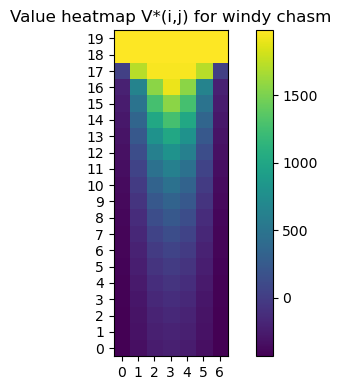

In [17]:
mask_20x7 = np.zeros((GRID_I, GRID_J), dtype=float)
V_grid = values_to_grid(mask_20x7, st2i_chasm, V_star)
plot_grid(V_grid, title="Value heatmap V*(i,j) for windy chasm")

In [21]:
# explicit initial distribution μ and policy π in code

# Number of states in the windy chasm MDP
n_chasm = mdp_chasm.n_states()

# Initial distribution μ over states: all probability mass at the start cell (0,3).
mu_chasm = np.zeros(n_chasm, dtype=float)
start_state = (0, 3)  # top-middle of the chasm, as in the Mini-2 description
start_idx = st2i_chasm[start_state]
mu_chasm[start_idx] = 1.0

# For clarity, renaming the optimal policy to pi_chasm to match the Mini-2 notation π.
# pi_chasm[s] is a dict mapping actions to probabilities, i.e. π(a | s).
pi_chasm = pi_star

gamma_chasm = mdp_chasm.gamma  # the discount factor γ used in this problem

mu_chasm, gamma_chasm

(array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 0.99)

#### (ii) Qualitative behavior of pi^*

For reasonable parameters (e.g. moderately large goal reward R, crash penalty -r,
and discount factor gamma close to 1), the optimal policy has the following shape:

- The policy tends to choose a **mostly straight path** towards the goal, trying to reach the
  right side in a small number of steps (because each step costs -1.
- However, because of the wind and the crash penalty, the drone **avoids rows that are too
  close to the top or bottom cliffs**.
- It typically prefers to travel in a **“safe corridor”** of central rows that have some margin
  before going out of bounds, especially in columns where the wind is strong.

In other words, pi^* is a balance between:

- **short paths** (to reduce the step cost),
- **risk avoidance** (to avoid crashes with large negative reward),
- and **wind dynamics** (columns with higher probability of vertical displacement are more
  dangerous, especially near the edges).

---

#### (iii) Center vs. risky paths

- When the wind is **weak** and the crash penalty is not huge, the optimal policy may cut
  closer to the “edges” to take a **shorter, slightly riskier path**.
- As soon as the wind gets strong or the crash penalty is large, the optimal policy shifts
  to a **more conservative path**, staying closer to the center rows where there is more
  vertical safety margin.

So the drone’s behavior changes from “staying on the shortest path” to “staying in the safe
middle lane” as the environment becomes more dangerous.


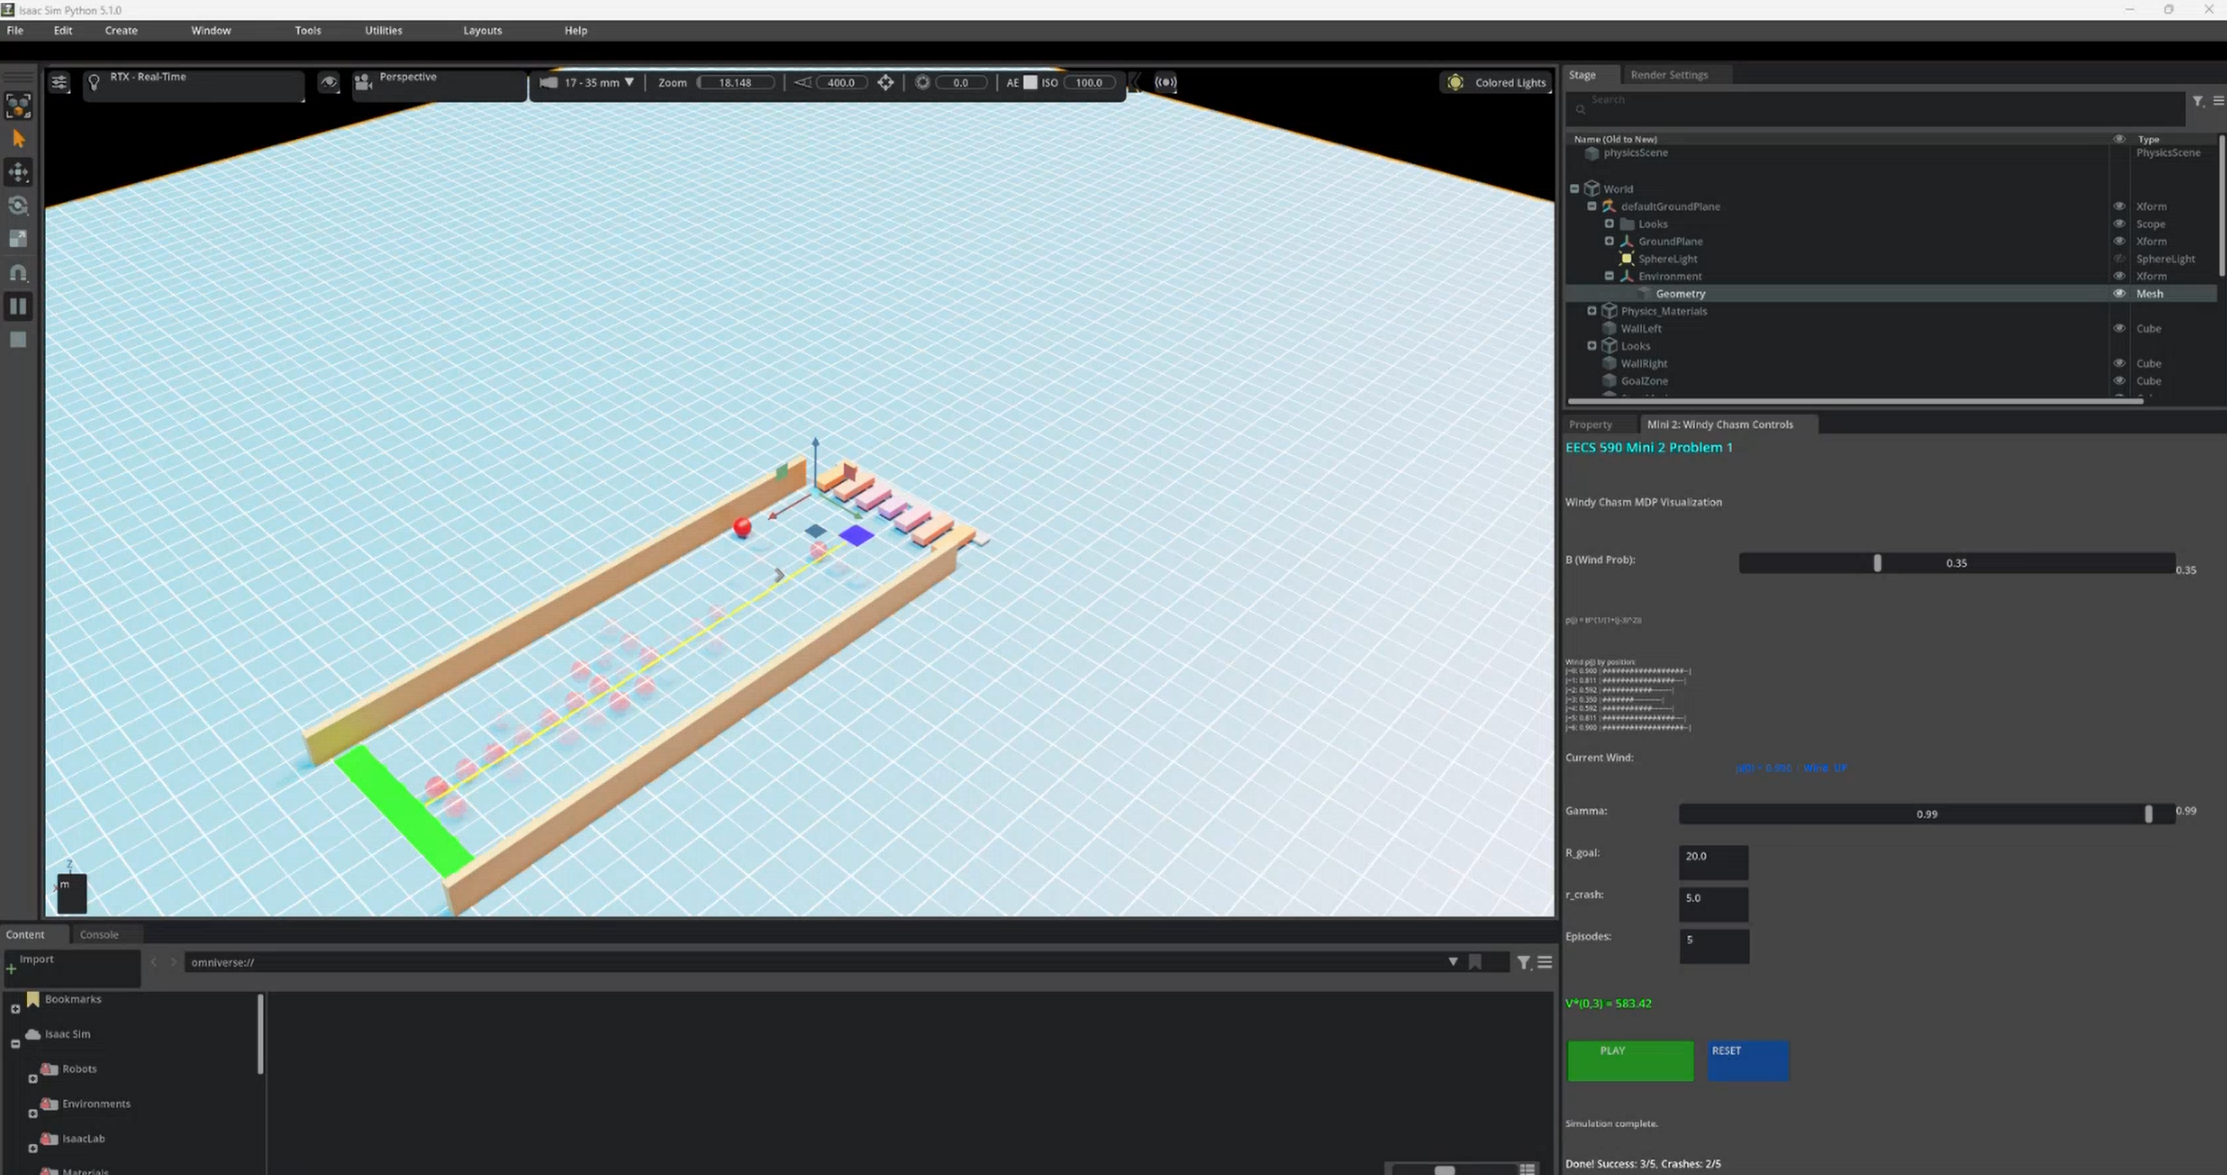

In NVIDIA Isaac Sim (Omniverse), I implemented an interactive visualization of the Windy Chasm MDP where the wind probability p(j) = B^(1/(1+(j-3)²)) varies with distance from the center line. By adjusting the base parameter B via a real-time UI slider, I observed that higher B values increase wind probabilities across all positions, resulting in more frequent crashes and lower optimal values V(0,3).

Submitting a video of Isaac Sim for same with Mini 2 assignment Solution.


---

#### (iv) What happens as the wind parameter p increases?

Here p controls how likely a strong vertical gust is in certain columns.

- For **small p**:
  - The wind rarely disturbs the drone.
  - The optimal policy tends to choose a **fast, almost straight line** path that may skim
    near the cliff edges, because the risk of actually being blown off is low.

- For **large p**:
  - The drone is frequently pushed up or down.
  - Near the cliff edges, even one or two gusts might cause a crash.
  - The optimal policy reacts by:
    - staying more in the **middle rows**,
    - possibly taking a **longer path** that avoids the windiest columns,
    - reducing horizontal speed in dangerous zones to regain safe vertical position.

So increasing p shifts pi^* from a **risk-taking** strategy to a more **risk-averse**
center-hugging strategy.

---

#### (v) Effect of setting the crash reward to -1

Suppose we change the crash reward from a large negative number (e.g. -20 to -1),
which is the same as the step cost.

Then:

- Crashing is **no longer much worse** than simply taking one extra step.
- In expectation, the cost of “taking a risky shortcut and maybe crashing” vs. “taking a safe
  but longer route” becomes much closer.

The qualitative policy effect:

- The optimal policy will become **more aggressive**:
  - It may intentionally pass closer to the cliff,
  - It may cooperate with the wind to reach the goal faster, even if that occasionally leads
    to a crash.
- In the extreme case where the crash penalty is exactly the same as a normal step, the drone
  is almost indifferent between “keep walking” and “crash now and restart”, so we lose the
  strong safety incentive.

This shows how important the **relative scale** of terminal rewards is: a large negative
crash penalty pushes the policy toward safety; a small penalty encourages “reckless” but
shorter paths.

---

### 2. CHALLENGE – Refining the model toward continuous dynamics

The goal of these sub-questions is to think of the 20 x 7 grid as a **coarse
approximation** and then refine it toward a more continuous physical model.

---

#### (a) Refining to a 60 x 21 grid (subdivide each cell)

We can refine the original coarse grid by cutting **each macro cell into 3 x 3 micro-cells**:

- Original grid: 20 x 7,
- New grid: 60 x 21 (each dimension multiplied by 3).

Interpretation:

- One “macro step” in the old world corresponds to **3 micro steps** in the new world.
- The goal region becomes a **block** of micro-cells corresponding to the original goal cell.
- Crash boundaries become lines of micro-cells at the top and bottom.

To keep the dynamics approximately consistent:

- **Horizontal motion:**
  - Instead of one big move of 1 column, the drone makes 3 smaller moves of 1/3
    column each. In the discrete grid, that just means moving 3 micro-cells in x per macro step.

- **Wind probability:**
  - In the original model, with probability p the drone is blown up/down by some amount.
  - In the refined model, we want the **overall probability of being blown within 3 micro steps**
    to match p.
  - If we let the micro-step wind probability be q, then
    $$
    1 - (1 - q)^3 \approx p,
    $$
    so
    $$
    q \approx 1 - (1 - p)^{1/3}.
    $$
  - This ensures that over 3 micro steps, the chance of experiencing wind is approximately \(p\).

- **Rewards:**
  - We want the total cost of moving one macro cell to still be -1.
  - So each micro step gets reward -1/3.
  - Reaching the goal or crashing at any micro-cell of the corresponding region gives +R or
    -r and terminates as before.

This 60 x 21 MDP is a **finer grid approximation** of the same physics we modeled in
the original 20 x 7 world.

---

#### (b) Taking a limit: continuous state on [0,6] x [0,19]

Next, we imagine the drone moving in continuous space:

- Vertical coordinate $$j \in [0,6]$$,
- Horizontal coordinate $$i \in [0,19]$$.

We can approximate this with a **non-uniform discretization**:

- Let dx = 0.05 in the vertical direction (fine resolution),
- Let dy = 1 in the horizontal direction (still aligned with columns).

Then:

- Vertical grid: about 6 / 0.05 = 120 levels,
- Horizontal grid: still 20 positions,

so we get a(20 x 120 grid.

Dynamics:

- Horizontal motion is mostly deterministic: in each time step you move from i to i+1
  (or a similar small increment).
- Vertical dynamics (wind) operate on the **continuous height**; our discrete model
  approximates them by letting the drone jump multiple dx’s with probabilities derived
  from a continuous wind profile(p(j).

If the drone is “winning too easily” (reaching the goal with high probability and low time),
we can increase the wind intensity parameter p to make the vertical noise stronger.

This gives an MDP that approximates a continuous system with state space
[0,6] x [0,19].

---

#### (c) Fixed velocity v and continuous time

Instead of discrete “steps” of size 1, we introduce:

- A **constant horizontal velocity** v,
- Continuous time $$t \in [0, T]$$.

Now, in a small time interval $$\Delta t$$, the drone travels distance $$v \Delta t$$ horizontally.

We can still approximate this with discrete time by choosing a small $$\Delta t$$ and treating one
MDP step as:

- Horizontal displacement: $$\Delta i = v \Delta t$$,
- Vertical displacement: determined by the wind process over that time interval.

If we decrease $$\Delta t$$, the time model becomes finer and approaches a continuous-time
stochastic process.

The main effect:

- Distances and wind effects both scale with **velocity** and **time**:
  - travel twice as fast → cover twice the horizontal distance,
  - but also experience wind for half the time each step (so we need to choose how the
    wind model scales with $$\Delta t$$).

---

#### (d) Defining the probability of wind via integrals

The statement suggests

$$
\int_{j_i}^{j_i + v t} p(x)\, dx
\quad\text{and}\quad
\int_{j_i}^{j_i + v(1-t)} dy
$$

and then a linear interpolation formula like

$$
\frac{p(j) + p(j + v t)}{2}\, t + p(j)(1 - v t).
$$

Intuitive interpretation:

- We now treat p(j) as a **continuous function** describing wind strength as a function of
  vertical position.
- Over a small time window of length t, as the drone moves horizontally and is possibly
  pushed vertically, it travels through a **range of heights**.
- The probability of being blown within that time is approximated by the **average value of
  p** over the relevant vertical interval, times the time fraction t.

So instead of a single constant probability per column, we approximate the **continuous
variation** of wind with height and time by integrating p(j) over the path or by using
a first-order (linear) interpolation of p at the start and end height.

In a fully continuous model, one would define the wind as a stochastic process and integrate
its effect along the trajectory. The discrete-time integral given in the problem is a
simple approximation of this idea.

---

#### (e) Interpolating the consequences of wind effects

Instead of applying discrete “jumps” in vertical position, we can interpolate **velocity**:

- Suppose when a p-event (a “wind gust”) occurs, we **add a vertical velocity
  v away from the center line** (say away from j = 3) for an interval of time
  of length 1.
- If during that interval another wind event occurs, we need to **combine** them:
  - A simple choice: if two p events occur in the same time window, we double the
    vertical velocity to 2v for that interval.
- Instead of thinking of vertical position jumping by $$\Delta j$$, we now think of the
  vertical position **following a continuous trajectory** governed by velocity:

  $$
  \frac{dj}{dt} = v_{\text{drift}}(t),
  $$

  where $$v_{\text{drift}}(t)$$ increases when wind events occur.

This changes the dynamics from “occasionally jump a cell up/down” to “occasionally
add a vertical drift that gradually moves the drone over time”.

In discrete approximation, we can simulate this by:

- Maintaining a vertical velocity component,
- At each time step, updating position by that velocity times $$\Delta t$$,
- Updating the velocity when wind events happen (e.g. adding v, or doubling to 2v if
  events overlap).

---

#### (f) Adding angles to the procedure

Now suppose we also track the **heading angle** $$\theta$$ of the drone:

- The state becomes $$(i, j, \theta)$$,
- The drone’s velocity is a vector with magnitude v and direction $$\theta$$,
- Wind can add additional vector components (e.g. vertical gusts, horizontal cross-winds).

Effects of adding angles:

1. The dynamics become **2D in velocity space**:
   - Horizontal and vertical motion are no longer independent.
   - A gust could change $$\theta$$ instead of just moving the drone up/down.

2. The state space becomes larger and continuous:
   - We might discretize $$\theta$$ into a small set of angles (e.g. 8 or 16 headings),
   - Or use function approximation instead of a tabular state.

3. The MDP becomes more realistic but much harder to solve with **standard tabular DP**.

To keep it tractable, we would likely:

- Discretize angle into a small set of headings,
- Use a coarser grid or function approximation for value and policy,
- Or move to continuous-state RL methods (e.g. actor–critic with continuous control)
  where $$\theta$$ is treated as a continuous variable.

---

**Summary for Problem 1**

- We extracted the optimal policy pi^* by greedily maximizing one-step lookahead using V^*.
- The policy’s qualitative behavior shifts from risky, short paths to safe, center-hugging
  paths as wind strength p and crash penalty increase.
- Setting the crash penalty to -1 makes crashes cheap and encourages much riskier behavior.
- The CHALLENGE parts illustrate how the discrete 20 x 7 MDP can be refined into
  finer grids, then into continuous state and time models, with wind modeled via integrals,
  velocities, and even angles, gradually bridging toward realistic physical models.


# Problem 2: Robot Motion Control via Reward Shaping
Consider an autonomous ground vehicle robot equipped with wheel encoders and a 360-degree
lidar sensor. Due to hardware imperfections, motor noise, slip, lag, and control loop oscillations,
commanding the robot to move forward rarely results in perfectly straight motion. Luckily, lidar
can be far more reliable than encoders. Your goal is to use reinforcement learning to finetune
movement.
Setup
The robot uses a Kalman filter to estimate its 2D pose (r, θ) from lidar scans and odometry. The
state space consists of discretized lidar readings.
A clever environment design is to use a cone-shaped corridor in front of the robot: think of
it like a “funnel” where the robot’s forward direction is aligned with the axis of symmetry of the
cone.
- If the robot moves straight, lidar readings in the left and right sectors of the forward view
are identical in expectation, radially and angularly.
- If the robot veers, one sector’s displacement and angles shrink while the other sector’s displacements
and angles grow, giving a direct geometric signal that the robot is off-course.
The action space consists of discrete adjustments to the left and right wheel motor encoder
thresholds, representing small increments or decrements to threshold values.

## Questions

(a). Propose a specific state representation that captures data from the lidar and the robot’s
deviation from straight-line motion. Justify why this representation is Markovian (or approximately
so) for the motion control task. ` If you have no idea what to do, you can start off
with the grid:` 
``` text
W
1 W
1 1 W
1 1 1 W
1 1 1 1 W
1 1 1 1 1 W
A 1 1 1 1 1 W
1 1 1 1 1 W
1 1 1 1 W
1 1 1 W
1 1 W
1 W
W

and consider how to turn asymmetry into a problematic state.

# Solution 2: Robot Motion Control via Reward Shaping

Here I design state, rewards, and discuss policy iteration qualitatively, as required by the mini.



# Answer (a): State representation and Markov property


We consider an autonomous ground robot with wheel encoders + 360° lidar, moving through a
cone-shaped corridor (“funnel”). The robot wants to go straight, but motors are noisy, there is
slip, lag, etc., so a straight command does not produce perfectly straight motion. Lidar is more
reliable than encoders, so we will use lidar-based features as our state.

A concrete, approximately Markov state:

- Split the forward lidar field of view into left and right cones.
- For each cone, compute summary stats: mean distance, minimum distance, maybe a few histogram bins.
- The state is a vector of these summaries, capturing how symmetric the corridor looks.

This is approximately Markov for the motion-control task because, given these summaries and the current wheel command, we can predict how the robot will drift and how the next lidar scan will look, without needing the full past history.

We assume the robot’s pose (r, θ) is estimated by a Kalman filter, and the state space
will be based on **discretized lidar readings**.

As an example cone-shaped corridor (top view) can be visualized as:

```text
          W
        1   W
      1   1   W
    1   1   1   W
  1   1   1   1   W
A   1   1   1   1   W
  1   1   1   1   W
    1   1   1   W
      1   1   W
        1   W
          W
```
- `A` is the robot’s starting cell.
- `1` cells indicate free corridor.
- `W` cells are walls.

If the robot is perfectly centered and going straight, the left and right halves of the lidar view
are symmetric. If it veers left or right, that symmetry breaks.

**Goal:** We want a state representation that:

1. Comes from lidar,

2. Captures how far the robot is from “perfectly straight” motion,

3. Is (approximately) Markov: the next-state distribution depends only on the current state and action.

**Step 1** – Split lidar into left and right sectors

Imagine we divide the forward 180° field of view into two big sectors:

- Left sector: angles 𝜃 ∈ [- 90 ∘,0∘]


- Right sector: angles 𝜃 ∈[0∘,+90∘]


Within each sector, we collect distances to obstacles from the lidar.

For each sector we compute simple summary statistics, for example:

-  dL,avg : average distance in the left sector


- dR,avg : average distance in the right sector

When the robot is centered, we expect dL,avg ≈ dR,avg
	
If the robot veers left, it gets closer to the left wall ⇒ dL,avg becomes smaller, and similarly dR,avg will be small if robot veers right.

**Step 2** Turn symmetry/asymmetry into a discrete state

We can define an asymmetry measure: Δ=dR,avg − dL,avg
	

- If Δ≈0: the robot is centered.

- If Δ>0: right side is farther → robot is too close to the left wall.

- If Δ<0: left side is farther → robot is too close to the right wall.

As we are not considering continuous state (for this assignment), so we categorize
Δ into a few categories:

- CENTER: ∣Δ∣<ϵ (nearly symmetric)

- LEFT-DRIFT-SMALL: Δ>0 but not too large (slightly left)

- LEFT-DRIFT-LARGE: Δ very positive (dangerously close to left wall)

- RIGHT-DRIFT-SMALL: Δ<0 moderately

- RIGHT-DRIFT-LARGE: Δ very negative (dangerously close to right wall and may crash)

We can also include a **forward distance** summary:


dfront: average distance to obstacles in a narrow cone directly ahead
(just for e.g. θ∈[−15∘,15∘]).

Discretize the front far into, say:

**FRONT-FAR:** plenty of room ahead

**FRONT-MID:** moderate distance

**FRONT-NEAR:** very close to something


We can define each state as a pair: s=(drift_class,front_class)

where:

`drift_class` ∈ {CENTER, LEFT-SMALL, LEFT-LARGE, RIGHT-SMALL, RIGHT-LARGE}

`front_class` ∈ {FAR, MID, NEAR}

For example:

`s`=(CENTER,FAR) → robot is roughly centered, lots of room ahead.


`s`=(LEFT-LARGE,MID) → robot is very close to left wall but still has some room forward.

This kind of state can be derived only from  lidar measurements.

**Why is this representation (approximately) Markov?**

As we studied Markov property:

`The future is independent of the past, given the present.` -- *David Silver*

For our motion control task in mini2, this means:

Given the current state `st` (which summarizes the geometry of the corridor around us) and the action `at`(our adjustment to wheel), the probability distribution of the next state st+1 does not depend on earlier history.

Why this is reasonable here:

- Lidar fully describes nearby environment geometry.

- Our drift_class + front_class summarize how centered we are and how close obstacles are ahead.

- The underlying corridor is static; only the robot moves.


For a fixed action (small change in left/right wheel thresholds), the effect on pose is statistically similar every time we are in the same geometric situation.


The pose estimate using the latest estimate and lidar gives a “best current guess” of where we are. (not dependent on past)

So, under these assumptions, our discretized lidar-based state is approximately Markov: the dynamics  P(s′∣s,a) depend only on current geometry and chosen wheel adjustment, not on the full past path.

## Question (b):
Design a reward function R: S × A → R defined by R(s, a) = E(Rt+1 | St = s,At = a) that
encourages forward motion and rotation corrections regardless of your encoder hardware.

## Answer: 

The assignment asks for: R(s, a) = E(Rt+1 | St = s,At = a) i.e. a reward that depends on current state and chosen action.

We want the robot to:

1. Move forward (don’t waste time),
2. Correct drift (reduce asymmetry),
3. Avoid getting too close to walls or obstacles.

We can design rewards in two layers:

1. `Base step reward`

At each step, penalize time:

Rbase =−1 for every non-terminal step (like in many gridworlds).

This encourages shorter paths.

2. `Drift and correction`

We can define some rules:

- Centered, going straight is good.

If *drift_class = CENTER* and we choose an action that keeps our robot essentially centered, we give a small bonus.

- Wrong direction corrections are bad.

If we are too close to the left wall and we push even more to the left, we penalize more.

- Corrective actions are slightly rewarded.

If we are too close to the left wall and we adjust to move right, give a bonus.

We can encode this using state + action only, by looking at drift_class and the sign of the action:

Let actions be a and:

a = LEFT-BIAS (slightly increase left wheel power → robot turns left)

a = RIGHT-BIAS (slightly increase right wheel power → robot turns right)

a = STRAIGHT (keep thresholds equal)
``` text
we can define drift_class:
  CENTER
  LEFT-SMALL, LEFT-LARGE
  RIGHT-SMALL, RIGHT-LARGE

  An example of reward table can be

drift_class	      action	   reward R(s,a)	           intuition
CENTER	         STRAIGHT	    -0.5	             moving straight while centered (slightly good)
CENTER 	         LEFT/RIGHT   	-1.2	             unnecessary steering → small extra penalty
LEFT-SMALL	     RIGHT-BIAS	    -0.8	             small drift, correcting a bit → okay
LEFT-SMALL	     STRAIGHT	    -1.0	             not correcting → standard penalty
LEFT-SMALL	     LEFT-BIAS	    -1.5	             steering wrong way → stronger penalty
LEFT-LARGE	     RIGHT-BIAS	    -0.5	             urgently need correction, reward “brave” fix
LEFT-LARGE	     STRAIGHT	    -2.0	             very dangerous state + not correcting
LEFT-LARGE	     LEFT-BIAS	    -3.0	             almost crash + steering into wall
RIGHT-SMALL	     LEFT-BIAS	symmetric to LEFT-SMALL	
RIGHT-LARGE	     LEFT-BIAS	symmetric to LEFT-LARGE  

```
3. `Terminal rewards`

To complete the definition:

- If lidar detects imminent collision (wall within some threshold) and we consider that a terminal `crash`:  R(s,a)=−R crash , e.g. -20 or -50.

- If the robot reaches a “success zone” (some distance forward, still centered):  R(s,a)=+R goal, e.g. +100 reward.

Now the reward function is a deterministic function of (s,a) and designed to:

- Push the robot to stay centered,

- Punish dangerous drift,

- Still penalize time steps so it doesn’t just wander forever.

## Question (c):
Apply policy iteration to this problem. Discuss potential challenges with convergence: What
aspects of the problem (continuous underlying state, sensor noise, hardware variability) might
make the empirical transition probabilities P(s′|s, a) difficult to estimate accurately? How
might you address these challenges?

## Answer:

We’re supposed to apply policy iteration and discuss challenges.

**Policy iteration and value iteration**  
  - **Policy evaluation**: given a fixed controller \\(\pi\\), we could (in principle) estimate
    \\(V^{\pi}\\)  by solving the Bellman equation with an approximate
    model of \\(P(s' \mid s,a)\\).
  - **Policy improvement**: adjust \\(\pi\\) to choose actions that move toward higher-valued states
    (closer to centered, safer configurations).  
  - Full **policy iteration** (evaluate \\(\pi\\), then improve \\(\pi\\), repeat) is conceptually valid,
    but in practice is challenging here because the state space is continuous and transition estimates
    are noisy, as discussed earlier in the Problem 2 answers.

    
Policy iteration requires estimates of transition probabilities P(s′|s, a). In our real robot setting, that’s tricky:

1. Underlying state is continuous.

- True pose (x,y,θ) and lidar readings are continuous.

- Our discrete state `s = (drift_class, front_class)` is a coarse quantization.

- The same (s,a) may correspond to many slightly different physical situations.

2. Sensor noise already mentioned in Mini 2 (lidar + Kalman filter).

`Kalman filter` is an algorithm that uses a series of measurements observed over time, including statistical noise and other inaccuracies, to produce estimates of unknown variables that tend to be more accurate than those based on a single measurement, by estimating a joint probability distribution over the variables for each time-step.

- Even if the robot repeats the same physical trajectory, measured distances will vary slightly due to noise.

- So observed transitions (s,a,s′) are stochastic both due to dynamics and measurement noise.

3. Hardware variability and drift.

- Motor response can change with battery level, temperature, wheel wear, floor friction, etc.

- The true P(s′|s, a)is not strictly stationary; it may change over time.

These factors make it hard to accurately estimate a single, fixed transition probability table.

Exact tabular policy iteration is conceptually clean but practically hard for a real robot with continuous, noisy sensors.

A more realistic setup:

Start with our discretized state and shaped reward,

`To address` these challanges we can use either:

- approximate model-based RL (noisy estimates of P),

- or model-free methods (Q-learning/actor–critic),

- and keep updating from real-world experience.

## Problem 3: Circuit Design via Sequential Decisions
An agent must design a digital logic circuit on a 3×3 grid to implement a target Boolean function.
The agent navigates the grid and places components to build the circuit from left to right.

**Environment**

The agent’s position (i, j) on the grid is part of the state, along with the current circuit configuration.
To avoid needless complexity, we impose the requirement that gates have fixed orientation:
inputs come from the left, top, and bottom, and outputs go to the right. We require, for simplicity,
that (0, 0) and (2, 0) are special source tiles that can inject input signals A and B into whatever
component is placed on them. Moreover, that (1, 2) is a special sink, C, that absorbs signals output
from components. Agent actions include:
- Move: up, down, left, right (within grid bounds)
- Place: wire, NAND gate (at current position)
- Remove: remove component (at current position)
- Done: finish and evaluate the circuit

**Goal**

Have a framework for an agent that designs a circuit that implements the 2-bit XOR function: In
particular, the signals A and B give the output a signal C = A XOR B

**Questions**

(a). Define a suitable state representation for this problem. What information must be included
in the state to make optimal decisions? Discuss whether your state representation makes the
problem Markovian.

(b) Propose a way of evaluating the test time action. How would you go about judging the
propagation of the A and B signals fairly? Would you treat this as a deterministic process
or use some other way?

(c) A 3 × 3 grid is very small and leads to unintended wire interactions However, it is very
necessary due to the state space explosion that happens when you introduce so many actions.
Impose “insulation” from (1, 1) to (2, 1) that blocks all signals between them.

(d) Analyze the complexity of applying value iteration to this type of problem. Estimate the size
of the state space just for going to the 4×4 case. and discuss whether standard tabular value
iteration is computationally feasible. What approximations or problem modifications might
make dynamic programming more tractable?

## Question (a). 

Define a suitable state representation for this problem. What information must be included in the state to make optimal decisions? Discuss whether your state representation makes the problem Markovian.

## Answer: 

We have a **3×3 grid**. The agent is supposed to walks around the grid and gradually builds a digital circuit
using:

`Actions`

- `Move`: up / down / left / right (stay within grid),
- `Place`: place a **wire** or a **NAND** gate at the current cell,
- `Remove`: remove the component at the current cell,
- `Done`: stop building and evaluate the circuit.

`Special tiles`:

- `(0,0)` is a source that injects input signal **A**,
- `(2,0)` is a source that injects input signal **B**,
- `(1,2)` is a sink where we read **C**, the output we want to match **XOR(A,B)**.

Orientation is fixed: signals flow left → right. Gates take their inputs from left/top/bottom and
output to the right.

---

### State representation and Markov property

We need a state representation that contains **enough information** so the agent can decide
what to place and where to move, and so that the process is (approximately) **Markov**.

For us A natural choice can be:
$$
s = (\text{agent\_pos}, \text{grid\_config}, \text{done\_flag})
$$
**1. Agent position**

Let

$$
\text{agent\_pos} = (i,j), \quad i,j \in \{0,1,2\}.
$$

represent which cell the agent is currently standing on.

**2. Grid configuration**

For each of the 9 cells, we record **what is currently placed there**.

- Some cells are **fixed** by the environment:
  - `(0,0)` = source A,
  - `(2,0)` = source B,
  - `(1,2)` = sink C.
- The remaining 6 cells can be in one of three states:
  - `EMPTY`
  - `WIRE`
  - `NAND`

We can encode the grid as a 2D array:

```text
grid[i,j] ∈ {EMPTY, WIRE, NAND, A-SOURCE, B-SOURCE, SINK}
```
`A/B source and sink cells are not changed by the agent.`

So the full grid configuration is essentially a 3×3 matrix of discrete symbols.

**3. Done flag**

done_flag ∈ {0, 1}

0 = still building,

1 = the agent has taken the Done action and the environment is in evaluation/terminal state.

This distinguishes “still editing the circuit” from “circuit frozen and evaluated”.


**Why this is Markovian?**

The Markov property says:

`The future depends only on the current state and action, not on the full history.`

Given our definition of s, the next state depends only on:

- The current grid configuration (which components are where),

- The agent’s current position (so we know where Move, Place, Remove apply),

- Whether we are already in done mode.

##### Examples:

1. `Move:`

From (i,j), action MoveRight leads deterministically to (i,j+1) (if within bounds),
and the grid configuration does not change.

2. `Place / Remove:`
At (i,j), if we do Place NAND, the new state is identical except for the entry
grid[i,j], which becomes NAND. We don’t need to remember how we got here.

3. `Done:`
When we choose Done, we freeze the grid (no more placement changes) and test the circuit.
The result of the test depends only on the final wiring, not on the order we placed gates.


Therefore, this state:

(agent_pos, grid_config, done_flag)


contains all the information needed to predict resulting states and rewards. No extra history is
needed, so the `problem is Markov` under our model.



## Question (b).
 Propose a way of evaluating the test time action. How would you go about judging the propagation of the A and B signals fairly? Would you treat this as a deterministic process or use some other way?


## Answer: 


When the agent chooses Done, we must decide how to evaluate the circuit.

We want to implement the XOR function:

C = A XOR B

So the correct truth table is:

``` text

A	B	C_target
--------------------
0	0	0
0	1	1
1	0	1
1	1	0
```

The circuit we built on the 3×3 grid is deterministic: given A and B, the wiring and NAND
gates will either produce the correct C or not.

There are two natural ways to turn this into a reward:

Option 1: Evaluate all 4 input combinations (deterministic test)

When Done is taken:

1. Test the circuit on all 4 input pairs:

(0,0),(0,1),(1,0),(1,1).

2. Count how many times the output C matches the target XOR output.

Let:
score=#{input pairs where C   circuit =Ctarget}

We can then define a terminal reward like:
``` text
R= +10 if score = 4 (perfect XOR)
   +5  if score = 3
    0   otherwise
```


This treats the `Done` evaluation as a deterministic function of the grid: same circuit ⇒ same reward every time.

Option 2: Sample inputs randomly (stochastic test)

Alternatively, every time Done is chosen we could:

1. Sample (A,B) uniformly at random from the 4 possibilities,

2. Evaluate the circuit once,

3. Reward +1 if the output is correct, 0 otherwise.

Then the expected reward is:


$$
\mathbb{E}[R \mid \text{circuit}] = \frac{\text{\# correct rows}}{4}.
$$


This creates an environment where the transition/reward at Done is stochastic, but with
known expectation.

For an RL assignment, Option 1 is cleaner and easier to debug (deterministic).
Option 2 is more “on-policy” and can be interesting if we want to treat input streams as random.

In either case, for fairness we should treat all four combinations equally (uniform
distribution) so the agent is not biased toward doing well only on a subset of input patterns.


## Question (c):

A 3 × 3 grid is very small and leads to unintended wire interactions However, it is very necessary due to the state space explosion that happens when you introduce so many actions. Impose “insulation” from (1, 1) to (2, 1) that blocks all signals between them.

## Answer:

Assumptions:

1. In a real circuit, wires can accidentally connect or share paths in ways that are hard to reason
about.

2. On a tiny 3×3 grid, a single wire placed at the “center” can accidentally connect multiple parts
of the circuit.

3. Adding “insulation” means preventing signals from travelling between two cells, even if both are wires.


`One simple way to model this is:`

- Treat the edge between cells (1,1) and (2,1) as non-conductive:

     - When we compute signal propagation, wires at (1,1) and (2,1) do not connect, even if both are wires.

- In graph terms:

  - The grid is a graph whose nodes are cells and edges represent possible connections.

  - We delete the edge connecting (1,1) and (2,1).

`We do not need to change the state representation; we change the transition / evaluation logic:`

- The grid_config still only stores the component in each cell.

- When evaluating the circuit or simulating signal flow, we use a connectivity rule that ignores
adjacency between (1,1) and (2,1).

`Effect:`

- Some paths that would have connected A/B to C through the center are no longer possible.

- This reduces weird, highly entangled circuits and can make learning and debugging easier.

## Question (d):

Analyze the complexity of applying value iteration to this type of problem. Estimate the size of the state space just for going to the 4×4 case. and discuss whether standard tabular value iteration is computationally feasible. What approximations or problem modifications might make dynamic programming more tractable?

## Answer:

**Complexity of value iteration and scaling to (4 x 4)**

We now analyze how big the state space can get and whether **tabular value iteration** is practical.

---

#### 1. Rough state count for the (3 x 3) case

In our state representation:

- There are **9 positions** for the agent.
- 3 of the 9 cells are **fixed**:
  - \(0,0\) = A source,
  - \(2,0\) = B source,
  - \(1,2\) = C sink.
- The remaining **6 cells** can each be in one of three states:
  - `EMPTY`,
  - `WIRE`,
  - `NAND`.

So the number of distinct grid configurations is

$$
\#\text{grid\_configs} \approx 3^6 = 729.
$$

For each configuration, the agent can be in any of 9 positions, and we have a
`done_flag` (0 or 1), so the total number of states is approximately


$$
|S| \approx 729 \times 9 \times 2 = 13,\!122 \text{ states.}
$$

This is already non-trivial, but still within the realm of tabular value iteration for a homework-scale problem.

---

#### 2. Scaling up to (4 x 4)

Now we have a (4x4) grid with the same idea:

- 16 total cells.
- Suppose we still have 3 fixed special cells (A source, B source, C sink).
- Then there are **13 configurable cells**.
- Each configurable cell $$\in \{\text{EMPTY}, \text{WIRE}, \text{NAND}\}$$, so

$$
\#\text{grid\_configs} \approx 3^{13} \approx 1.6 \times 10^6.
$$

Agent positions: 16 possible cells.

Add a `done_flag` again:

$$
|S| \approx 3^{13} \times 16 \times 2
      \approx 1.6 \times 10^6 \times 32
      \approx 5.1 \times 10^7.
$$

So we are looking at **tens of millions of states**.  
With multiple actions (`move`, `place`, `remove`, `done`) and possibly dense transitions,
this is too large for:

- storing a full \(V(s)\) table and iterating over all states repeatedly,  
- tabular value iteration with full sweeps over the entire state space.

Even **enumerating** all states explicitly is complicated.

---

#### 3. Is standard tabular value iteration feasible?

- For the **\(3 x 3)** grid:
  - Yes, in principle:
    - on the order of \(10^4\) states,
    - a handful of actions,
    - relatively simple transition structure.
  - For a teaching / research prototype, tabular methods are OK.

- For the **(4 x 4)** grid:
  - Not really:
    - tens of millions of states,
    - each sweep in value iteration touches every state,
    - memory and CPU time become a serious problem.

So in practice, we’d need to move away from a fully enumerated state space.

---

#### 4. Approximations / modifications to make DP more tractable

Several ideas:

1. **Restrict the design space**

   - Limit the number of gates/wires the agent can place.
   - For example, “at most 5 NAND gates” and “no more than 8 wire segments”.
   - This drastically cuts down the number of possible grid configurations.

2. **Use a higher-level representation**

   - Instead of raw grid cells, describe the circuit by a small set of logical features, e.g.:
     - “Does the output C depend on A?”
     - “Does the output C depend on B?”
     - “How many layers of NANDs?” etc.
   - This compresses many different physical layouts that are functionally equivalent into one abstract state.

3. **Factor the state space**

   - Treat each row or column as a “module”.
   - Solve RL or DP on each module, then combine them (hierarchical RL / modular design).

4. **Use approximate dynamic programming / RL**

   - Replace the tabular $$V(s)$$ with a function approximator $$V_\theta(s)$$.
   - Features could include: number of gates, estimated correctness on sample inputs,
     connectivity of A to C, etc.
   - Then use approximate value iteration or Q-learning with function approximation.

5. **Search-based methods + RL**

   - Treat circuit design more like **search in design space** (e.g. Monte Carlo Tree Search,
     genetic algorithms) and use RL to guide exploration rather than enumerating all states.

---

**In short:**

- On a **$$3 \times 3$$** grid, tabular value iteration is feasible for didactic purposes.
- On a **$$4 \times 4$$** grid and beyond, the combinatorial explosion in circuit configurations
  makes strict tabular dynamic programming unrealistic; we need **restrictions, abstractions,
  or function approximation** to keep things tractable.
